In [1]:
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.impute import *
from sklearn.compose import *
from category_encoders import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Preprocessing and Feature Objects

In [2]:
sales = pd.read_csv('summer_products.csv')

In [3]:
# It isn't included in pipeline TransformedTargetRegressor bc i don't need to transform y back
class ResponseColumnTransfomer(BaseEstimator, TransformerMixin):
    """Prepare response column. When units_sold>=1000, set 1, else set 0."""

    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        X[self.columns] = 1*(X[self.columns] >= 1000)
        return X

    def fit(self, X, y=None):
        return self

In [4]:
rcf = ResponseColumnTransfomer(columns='units_sold')
sales = rcf.fit(sales).transform(sales)

In [5]:
# delete most string-type columns, ids, website links and images
x_cols = ['price', 'retail_price', 'uses_ad_boosts', 'rating', 'badges_count',
          'badge_local_product', 'badge_product_quality', 'badge_fast_shipping',
          'product_variation_inventory', 'product_color', 'product_variation_size_id',
          'shipping_option_name', 'shipping_option_price', 'shipping_is_express',
          'countries_shipped_to', 'origin_country', 'merchant_rating_count',
          'merchant_rating', 'merchant_has_profile_picture']
y_col = 'units_sold'  # response variable

X = sales[x_cols]
y = sales[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
class CleanColor(BaseEstimator, TransformerMixin):
    """Clean product_color column"""

    def __init__(self, columns):
        self.columns = columns

    def clean_color(self, color):
        if '&' in color.lower():
            return('multicolor')
        elif 'blue' in color.lower() or 'navy' in color.lower():
            return('blue')
        elif 'green' in color.lower():
            return('green')
        elif 'black' in color.lower():
            return ('black')
        elif 'white' in color.lower() or 'silver' in color.lower():
            return ('white')
        elif 'brown' in color.lower():
            return ('brown')
        elif 'grey' in color.lower() or 'lightgray' in color.lower():
            return ('grey')
        elif 'pink' in color.lower():
            return ('pink')
        elif 'red' in color.lower() or 'burgundy' in color.lower() or 'wine' in color.lower() or 'claret' in color.lower():
            return ('red')
        elif 'yellow' in color.lower():
            return ('yellow')
        elif 'purple' in color.lower() or 'violet' in color.lower():
            return ('purple')
        elif 'coffee' in color.lower() or 'camel' in color.lower() or 'khaki' in color.lower():
            return ('brown')
        elif 'nude' in color.lower() or 'ivory' in color.lower():
            return ('beige')
        elif color not in ['multicolor', 'beige', 'brown', 'purple', 'yellow',
                           'red', 'pink', 'grey', 'white', 'black', 'blue', 'green']:
            return ('other')
        else:
            return (color)

    def transform(self, X, y=None):
        target = X[self.columns].astype(str)
        X[self.columns] = target.apply(self.clean_color)
        return X

    def fit(self, X, y=None):
        return self

In [7]:
class CleanSize(BaseEstimator, TransformerMixin):
    """Clean product_variation_size_id column"""

    def __init__(self, columns):
        self.columns = columns

    def clean_size(self, size):
        if 'xxs' in size:
            return ('2xs')
        if 'xxl' in size or 'xl' in size or '2xl' in size or '3xl' in size or '4xl' in size or '5xl' in size:
            return ('l')
        elif size not in ['s', 'xs', '2xs', 'm', 'xl', 'l']:
            return ('other')
        else:
            return (size)

    def transform(self, X, y=None):
        X[self.columns] = X[self.columns].astype(str)\
                                         .str.lower()\
                                         .str.replace('[-/()&.]', ' ')\
                                         .str.replace('cm', '')\
                                         .str.replace('inch', '')\
                                         .str.replace('size', '')\
                                         .str.replace('ml', '')\
                                         .str.replace('xxxxxxl', '2xl')\
                                         .str.replace('xxxxxl', '2xl')\
                                         .str.replace('xxxxl', '2xl')\
                                         .str.replace('xxxl', '2xl')\
                                         .str.replace('xxl', '2xl')\
                                         .str.strip()\
                                         .str.replace('daughter m', 'm')\
                                         .str.replace('25 s', 's')
        X[self.columns] = X[self.columns].apply(self.clean_size)
        return X

    def fit(self, X, y=None):
        return self

# Fitting Models

## BayesianRidge

In [39]:
cat_col = (X.dtypes == object)

num_pipe = Pipeline([('scaler', StandardScaler()),
                     ('quant', QuantileTransformer(output_distribution='normal'))])
# normalization does improve the perforemance

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', num_pipe, ~cat_col),
                                               ('cat', cat_pipe, cat_col)])

In [9]:
transformer = QuantileTransformer(output_distribution='normal')
br = BayesianRidge()
transformed_target = TransformedTargetRegressor(regressor=br,
                                                transformer=transformer)
# add QuantileTransformer for target, so regression model can be used for classification.

pipe_br = Pipeline([('cc', CleanColor(columns='product_color')),
                    ('cs', CleanSize(columns='product_variation_size_id')),
                    ('preprocessor', preprocessor),
                    ('imputer', IterativeImputer()),
                    ('tr', transformed_target)
                    ])
# IterativeImputer before training is a must,
# otherwise shows error: Input contains NaN, infinity or a value too large for dtype('float64')

In [10]:
pipe_br['tr'].get_params()

{'check_inverse': True,
 'func': None,
 'inverse_func': None,
 'regressor__alpha_1': 1e-06,
 'regressor__alpha_2': 1e-06,
 'regressor__alpha_init': None,
 'regressor__compute_score': False,
 'regressor__copy_X': True,
 'regressor__fit_intercept': True,
 'regressor__lambda_1': 1e-06,
 'regressor__lambda_2': 1e-06,
 'regressor__lambda_init': None,
 'regressor__n_iter': 300,
 'regressor__normalize': False,
 'regressor__tol': 0.001,
 'regressor__verbose': False,
 'regressor': BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
               compute_score=False, copy_X=True, fit_intercept=True,
               lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
               normalize=False, tol=0.001, verbose=False),
 'transformer__copy': True,
 'transformer__ignore_implicit_zeros': False,
 'transformer__n_quantiles': 1000,
 'transformer__output_distribution': 'normal',
 'transformer__random_state': None,
 'transformer__subsample': 100000,
 'transformer': QuantileTransf

In [11]:
hyperparameters = dict(tr__regressor__n_iter=[300, 500, 1000, 1500, 2000, 3000],
                       tr__regressor__normalize=[True, False],
                       tr__regressor__tol=[0.001, 0.01, 0.1])

for i in range(10):
    clf_rand_cv = RandomizedSearchCV(estimator=pipe_br,
                                     param_distributions=hyperparameters,
                                     n_iter=30,
                                     cv=5,
                                     n_jobs=-1,
                                     verbose=False)
    clf_rand_cv.fit(X_train, y_train)
    print(clf_rand_cv.best_params_)
    print(clf_rand_cv.best_score_)

{'tr__regressor__tol': 0.001, 'tr__regressor__normalize': False, 'tr__regressor__n_iter': 3000}
-0.1275624750692217
{'tr__regressor__tol': 0.01, 'tr__regressor__normalize': False, 'tr__regressor__n_iter': 500}
-0.1275624750692217
{'tr__regressor__tol': 0.001, 'tr__regressor__normalize': False, 'tr__regressor__n_iter': 300}
-0.1275624750692217
{'tr__regressor__tol': 0.1, 'tr__regressor__normalize': False, 'tr__regressor__n_iter': 1000}
-0.1275624750692217
{'tr__regressor__tol': 0.001, 'tr__regressor__normalize': False, 'tr__regressor__n_iter': 300}
-0.1275624750692217
{'tr__regressor__tol': 0.01, 'tr__regressor__normalize': False, 'tr__regressor__n_iter': 1500}
-0.1275624750692217
{'tr__regressor__tol': 0.1, 'tr__regressor__normalize': False, 'tr__regressor__n_iter': 300}
-0.1275624750692217
{'tr__regressor__tol': 0.01, 'tr__regressor__normalize': False, 'tr__regressor__n_iter': 1000}
-0.1275624750692217
{'tr__regressor__tol': 0.001, 'tr__regressor__normalize': False, 'tr__regressor__n_

**In practice, we should put CleanColor() and CleanSize() at the begining. Including them in the pipeline even RandomizedSearch will show severe computational complexity. But it is required by hw instructions.**

In [12]:
hypo = {'alpha_1': 1e-06,
        'alpha_2': 1e-06,
        'alpha_init': None,
        'compute_score': False,
        'copy_X': True,
        'fit_intercept': True,
        'lambda_1': 1e-06,
        'lambda_2': 1e-06,
        'lambda_init': None,
        'n_iter': 3000,
        'normalize': False,
        'tol': 0.001,
        'verbose': False}

transformer = QuantileTransformer(output_distribution='normal')
br = BayesianRidge(**hypo)

transformed_target_regr = TransformedTargetRegressor(regressor=br,
                                                     transformer=transformer)

In [13]:
pipe_br = Pipeline([('cc', CleanColor(columns='product_color')),
                    ('cs', CleanSize(columns='product_variation_size_id')),
                    ('preprocessor', preprocessor),
                    ('imputer', IterativeImputer()),
                    ('tr', transformed_target)
                    ])

In [14]:
model_br = pipe_br.fit(X_train, y_train.values.ravel())

In [15]:
preds = model_br.predict(X_test)

### Evaluation Metric

### Confusion Matrix

In [17]:
cm = confusion_matrix(y_test, preds)
cm

array([[24, 38],
       [ 9, 87]])

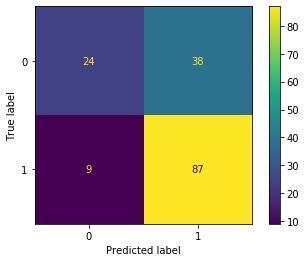

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

cmd = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd.plot()

### F1 Score

In [19]:
f1_score(y_test, preds)

0.7873303167420814

## Decision Tree

In [20]:
pipe_dt = Pipeline([('cc', CleanColor(columns='product_color')),
                    ('cs', CleanSize(columns='product_variation_size_id')),
                    ('preprocessor', preprocessor),
                    ('imputer',IterativeImputer()),
                    ('clf', DecisionTreeClassifier())])

In [21]:
hyperparameters = dict(clf__criterion        = ['gini','entropy'],
                       clf__max_depth = [10,20,30,40,50,60],
                       clf__min_samples_split = [1,2,3,4,5],
                       clf__min_samples_leaf = [1,2,3,4,5],
                       clf__min_weight_fraction_leaf = [0.0,0.1,0.2],
                       clf__max_features = ['auto', 'sqrt', 'log2'],
                       clf__class_weight = ['balanced'])

for i in range(10):
    clf_rand_cv = RandomizedSearchCV(estimator=pipe_dt, 
                              param_distributions=hyperparameters, 
                              n_iter=30,
                              cv=5, 
                              n_jobs=-1,
                              verbose=False)
    model = clf_rand_cv.fit(X_train, y_train)
    print(clf_rand_cv.best_params_) 
    print(clf_rand_cv.best_score_)

{'clf__min_weight_fraction_leaf': 0.0, 'clf__min_samples_split': 4, 'clf__min_samples_leaf': 1, 'clf__max_features': 'auto', 'clf__max_depth': 60, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced'}
0.7272084805653709
{'clf__min_weight_fraction_leaf': 0.0, 'clf__min_samples_split': 4, 'clf__min_samples_leaf': 3, 'clf__max_features': 'sqrt', 'clf__max_depth': 50, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced'}
0.7123674911660778
{'clf__min_weight_fraction_leaf': 0.0, 'clf__min_samples_split': 3, 'clf__min_samples_leaf': 5, 'clf__max_features': 'auto', 'clf__max_depth': 50, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced'}
0.7328621908127209
{'clf__min_weight_fraction_leaf': 0.0, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_features': 'auto', 'clf__max_depth': 30, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced'}
0.719434628975265
{'clf__min_weight_fraction_leaf': 0.0, 'clf__min_samples_split': 3, 'clf__min_samples_leaf': 2, 'clf_

**In practice, we should put CleanColor() and CleanSize() at the begining. Including them in the pipeline even RandomizedSearch will show severe computational complexity. But it is required by hw instructions.**

In [30]:
pipe_dt = Pipeline([('cc', CleanColor(columns='product_color')),
                    ('cs', CleanSize(columns='product_variation_size_id')),
                    ('preprocessor', preprocessor),
                    ('imputer',IterativeImputer()),
                    ('clf', DecisionTreeClassifier(min_samples_split=2,
                                                   min_samples_leaf=1,
                                                   max_features='auto',
                                                   max_depth=20,
                                                   criterion='entropy',
                                                   class_weight='balanced'))])
model_dt = pipe_dt.fit(X_train, y_train)

In [31]:
preds = model_dt.predict(X_test)

### Evaluation Metric

### Confusion Matrix

In [32]:
cm = confusion_matrix(y_test,preds)
cm

array([[42, 20],
       [12, 84]])

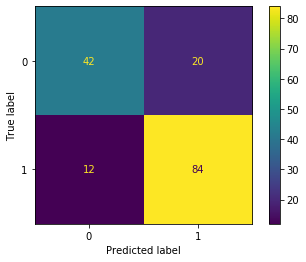

In [33]:
cmd = ConfusionMatrixDisplay(cm, display_labels=['0','1'])
cmd.plot()

### F1 Score

In [34]:
f1_score(y_test,preds)

0.8400000000000001

### ROC Curve

In [35]:
probs = model_dt.predict_proba(X_test)[:,1]

In [36]:
roc_auc_score(y_test,probs)

0.7755376344086021

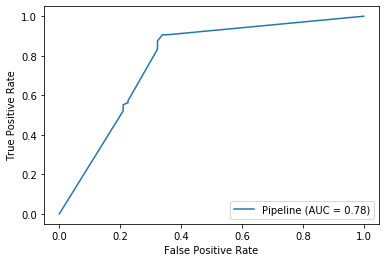

In [37]:
plot_roc_curve(pipe_dt, X_test, y_test) 
plt.show()  